In [1]:
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pdb
import scipy
from scipy.optimize import minimize, fmin
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
import matplotlib
from mpl_toolkits import mplot3d
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['tahoma']

In [2]:
""" 
Obtaining data from a given expt
"""
csv_test = pd.read_csv('subjectDataForPlots/allTrials_noBias.csv')
csv_data = pd.read_csv('subjectDataForPlots/noContextData/6149fb48b3daf85724de9b4b_categorization_task_2021-10-12_08h49.57.806.csv');
                       

In [3]:
n_tones = 3
n_trials = csv_data.shape[0]-47

"""
Get tones and values of keys pressed
"""
test_columns = list(csv_test.columns)
test_tones_name = test_columns.index('Name')
test_tones_col_idx = test_columns.index('Tones')
df_names = (csv_test.iloc[0:600,test_tones_name]).values
df_tones = (csv_test.iloc[0:600,test_tones_col_idx]).values

tones_array_orig = np.zeros((n_trials,n_tones))
tones_array_idxs_keep = []

for i_wav in range(603):
    if isinstance(csv_data['Name'][i_wav+46],str):
        tones_array_orig[i_wav,:] = np.array(df_tones[np.where(csv_data['Name'][i_wav+46]
                                                               ==df_names)[0]][0][1:-1].split(',')).astype(float)  
        tones_array_idxs_keep += [i_wav]

        
df_tones = np.copy(tones_array_orig[tones_array_idxs_keep,:])
df_corrans = np.copy(csv_data['corrAns'][46:csv_data.shape[0]])[tones_array_idxs_keep]
df_keys = np.copy(csv_data['test_resp.keys'][46:csv_data.shape[0]])[tones_array_idxs_keep]

In [4]:
"""
Find no response cases in the expt
"""
no_response = np.intersect1d(np.where(df_keys!='h')[0],np.where(df_keys!='l')[0])
print("Did not respond to: ",no_response)

"""
Convert keys ['l','h'] to [0,1] and calculate accuracies
"""
corrans_num_orig = np.zeros_like(df_corrans)
corrans_num_orig[df_corrans == 'h'] = 1

keys_num_orig = np.zeros_like(df_keys)
keys_num_orig[df_keys == 'h'] = 1

corrans_num = corrans_num_orig[:600]
keys_num = keys_num_orig[:600]
tones_array = df_tones[:600]
print("Got correct: ", np.sum(keys_num==corrans_num)/len(tones_array))
print("Got high correct: ", np.sum((keys_num)*(corrans_num))/np.sum(corrans_num))
print("Got low correct: ", np.sum((1-keys_num)*(1-corrans_num))/np.sum(1-corrans_num))

"""
Defining expt variable
"""

trial_tones = np.repeat(tones_array,1,axis = 0)
trial_behaviour = np.reshape(keys_num,np.prod(keys_num.shape)) 
#this has been changed to check how values change with observer responses

expt_tones = np.arange(90,3000,1) #array of possible true tones
log_freq_seq_array = np.arange(0.6,4.7,0.1)
log_freq_percept = np.arange(0.6,4.7,0.1) # array of possible perceptual tones

idxs_with_response = np.delete(np.arange(len(trial_tones)),no_response)
trial_tones = trial_tones[idxs_with_response,:]
trial_behaviour = trial_behaviour[idxs_with_response]
trial_corrans = corrans_num[idxs_with_response]


Did not respond to:  [326 340 359]
Got correct:  0.6233333333333333
Got high correct:  0.6478405315614618
Got low correct:  0.5986622073578596


In [5]:
def gaussian(x, mean, sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))

def Tones3dgrid(latentTones, sigma):    
    
    input_array_0 = np.expand_dims(gaussian(log_freq_percept, latentTones[0], sigma), axis = 1)
    input_array_1 = np.expand_dims(gaussian(log_freq_percept, latentTones[1], sigma), axis = 1)
    input_array_2 = np.expand_dims(gaussian(log_freq_percept, latentTones[2], sigma), axis = 1)
    s0 = 1/np.sum(input_array_0); 
    s1 = 1/np.sum(input_array_1); 
    s2 = 1/np.sum(input_array_2);
    input_array_0 *= s0; 
    input_array_1 *= s1; 
    input_array_2 *= s2; 
    
    input_array_mat = np.expand_dims(input_array_0@input_array_1.T,axis=2)@(input_array_2.T) #p(T1,T2..|H)   
                                     
    return input_array_mat

def mixedDistributionLikelihood(pBack_position, freqInput, likelihood_low_tones, likelihood_high_tones):
    likelihood_mixed_high = pBack_position*(1/len(freqInput)) + (1-pBack_position)*likelihood_high_tones
    likelihood_mixed_high /= likelihood_mixed_high.sum() #normalizing
    likelihood_mixed_high = np.expand_dims(likelihood_mixed_high, axis = 1)
    
    likelihood_mixed_low = pBack_position*(1/len(freqInput)) + (1-pBack_position)*likelihood_low_tones
    likelihood_mixed_low /= likelihood_mixed_low.sum() #normalizing
    likelihood_mixed_low = np.expand_dims(likelihood_mixed_low, axis = 1)
    
    return likelihood_mixed_high, likelihood_mixed_low

def posterior_array(freq_input, p_back, log_prior):
    """
    Arguments: 
    freq_input - range of all possible frequencies (percepts?)
    p_back - prob of background
    p_low - prob of low condition
    log_prior - list of prior parameters
    """
    
    log_prior_low_mean = log_prior[0]; log_prior_low_sigma = log_prior[2];
    log_prior_high_mean = log_prior[1]; log_prior_high_sigma = log_prior[2];
    
    likelihood_low = gaussian(x=freq_input, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    likelihood_high = gaussian(x=freq_input, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    
    [likelihood_mixed_high_position1, 
     likelihood_mixed_low_position1] = mixedDistributionLikelihood(p_back[0], freq_input, 
                                                                   likelihood_low, likelihood_high)
    [likelihood_mixed_high_position2, 
     likelihood_mixed_low_position2] = mixedDistributionLikelihood(p_back[1], freq_input, 
                                                                   likelihood_low, likelihood_high)
    [likelihood_mixed_high_position3, 
     likelihood_mixed_low_position3] = mixedDistributionLikelihood(p_back[2], freq_input,
                                                                   likelihood_low, likelihood_high)
        
    likelihood_alltones_low = (np.expand_dims(likelihood_mixed_low_position1@np.transpose
                                             (likelihood_mixed_low_position2),axis=2)
                               @np.transpose(likelihood_mixed_low_position3))
    
    likelihood_alltones_high = (np.expand_dims(likelihood_mixed_high_position1@np.transpose
                                             (likelihood_mixed_high_position2),axis=2)
                                @np.transpose(likelihood_mixed_high_position3))

    return [likelihood_alltones_high, likelihood_alltones_low]


In [6]:
"""
Generative process of experimental task
"""
def task(freq_seq, lm, hm, s, n_trials = 10, n_tones = 3, p_low = 0.5, p_back = 0.3):
    expt_log_freq_seq_array = np.arange(np.log10(freq_seq[0]), np.log10(freq_seq[-1]), np.log10(1003/1000)*40)
    print(expt_log_freq_seq_array)
    log_freq_seq_mid = np.median(expt_log_freq_seq_array)
    log_freq_low = [lm,s]#[log_freq_seq_mid - 0.15,0.1]  #low freq condition is gaussian 
    log_freq_high = [hm,s]#[log_freq_seq_mid + 0.15,0.1] #high freq condition is gaussian
    trial_tones = []
    dist_chosen = []
    kind_of_tones = []

    for trial in range(n_trials):
        signal_rand = np.random.random()
        low_dist = signal_rand < p_low #choosing true tone from either low or high condition
        tones = []
        tone_kind = []
        for n_tone in range(n_tones):
            signal_back = np.random.random()
            background = signal_back < p_back #choosing background or true tone
            if background:
                nearest_log_tone = np.random.choice(expt_log_freq_seq_array)
                #background freq is chosen from a uniform distribution
                tone_kind.append(0)
            else: 
                if low_dist:
                    tone = min(max(np.random.randn()*log_freq_low[1] + log_freq_low[0],
                                   expt_log_freq_seq_array[0]),expt_log_freq_seq_array[-1])                    
                    tone_kind.append(1)
                else:
                    tone = min(max(np.random.randn()*log_freq_high[1] + log_freq_high[0],
                                   expt_log_freq_seq_array[0]),expt_log_freq_seq_array[-1])
                    tone_kind.append(2)
                nearest_log_tone = expt_log_freq_seq_array[np.argmin(np.abs(expt_log_freq_seq_array - tone))]
            nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - 10**nearest_log_tone))]        
            tones.append(nearest_tone)
        trial_tones.append(tones)
        dist_chosen.append(1-low_dist)
        kind_of_tones.append(tone_kind)
    return trial_tones, dist_chosen, kind_of_tones, log_freq_low, log_freq_high


"""
Simulating participant behaviour
"""
def generate_behaviour(trial_tones, n_tones, prob_back, prob_low, log_prior_params, sigma_sensory):  

    all_trial_tones = np.empty((len(trial_tones),n_tones))
    all_trial_behaviour = np.empty((len(trial_tones),1))
    probability_sim_high = np.zeros((len(trial_tones),1))

    [LikelihoodLatentTonegivenHigh,
     LikelihoodLatentTonegivenLow] = posterior_array(log_freq_seq_array, 
                                                     p_back=prob_back, log_prior=log_prior_params)

    LikelihoodPerceptgivenHigh = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))
    LikelihoodPerceptgivenLow = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))

    for itrue1 in range(len(log_freq_percept)):
        for itrue2 in range(len(log_freq_percept)):
            for itrue3 in range(len(log_freq_percept)):
                probPerceptgivenLatentTones = Tones3dgrid([log_freq_percept[itrue1],
                                                           log_freq_percept[itrue2],
                                                           log_freq_percept[itrue3]],sigma=sigma_sensory)
                LikelihoodPerceptgivenHigh \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenHigh[itrue1,itrue2,itrue3]
                LikelihoodPerceptgivenLow \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenLow[itrue1,itrue2,itrue3]
    probHighgivenPercept = LikelihoodPerceptgivenHigh*(1-prob_low)/\
    (LikelihoodPerceptgivenHigh*(1-prob_low) + LikelihoodPerceptgivenLow*prob_low)

    for i_stim in range(len(trial_tones)):
        input_array = np.random.normal(loc=np.log10(trial_tones[i_stim]),scale=sigma_sensory,
                                       size=(n_tones,))
        #pick tones from the gaussian with mean as log(true_tone) and sensory sigma 0.1    

        perc_tone_idxs = np.zeros((n_tones,1),dtype=int)
        for i in range(n_tones):
            perc_tone_idxs[i] = np.argmin(np.abs(log_freq_percept-input_array[i]))
        posterior_perc_tone = probHighgivenPercept[perc_tone_idxs[0],perc_tone_idxs[1],perc_tone_idxs[2]]
        all_trial_behaviour[i_stim,:] = int(np.squeeze(posterior_perc_tone) > 0.5)
        all_trial_tones[i_stim,:] = trial_tones[i_stim] 

        gaussian_array_mat = Tones3dgrid(np.array([np.log10(trial_tones[i_stim][0]),
                                                   np.log10(trial_tones[i_stim][1]),
                                                   np.log10(trial_tones[i_stim][2])]),sigma=sigma_sensory)         
        probability_sim_high[i_stim] = np.sum(np.multiply(probHighgivenPercept>0.5, gaussian_array_mat))

    return all_trial_tones, all_trial_behaviour, probability_sim_high

"""
Fitting using MLE and grid search
"""
def MLE(params):
    log_prior_low_mean, log_prior_high_mean, log_prior_sigma = [2.55, 2.85, 0.1]
    sigma_sensory, prob_back_pos1, prob_back_pos2, prob_back_pos3, prob_low = params
    prob_back = [prob_back_pos1, prob_back_pos2, prob_back_pos3]
    
    [LikelihoodLatentTonegivenHigh,
     LikelihoodLatentTonegivenLow] = posterior_array(log_freq_seq_array, 
                                                     p_back=prob_back, log_prior=[2.55, 2.85, 0.1])

    LikelihoodPerceptgivenHigh = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))
    LikelihoodPerceptgivenLow = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))
    
    for itrue1 in range(len(log_freq_seq_array)):
        for itrue2 in range(len(log_freq_seq_array)):
            for itrue3 in range(len(log_freq_seq_array)):
                probPerceptgivenLatentTones = Tones3dgrid([log_freq_seq_array[itrue1],
                                                           log_freq_seq_array[itrue2],
                                                           log_freq_seq_array[itrue3]],sigma=sigma_sensory)                                                        
                LikelihoodPerceptgivenHigh \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenHigh[itrue1,itrue2,itrue3]
                LikelihoodPerceptgivenLow \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenLow[itrue1,itrue2,itrue3]
    probHighgivenPercept = LikelihoodPerceptgivenHigh*(1-prob_low)/\
    (LikelihoodPerceptgivenHigh*(1-prob_low) + LikelihoodPerceptgivenLow*(prob_low))
        
    neg_ll = 0; 
    probability_high = np.zeros((len(trial_tones),1))
    for i_trial in range(len(trial_tones)):
        input_array_mat = Tones3dgrid(np.array([np.log10(trial_tones[i_trial][0]),
                                               np.log10(trial_tones[i_trial][1]),
                                               np.log10(trial_tones[i_trial][2])]),sigma=sigma_sensory)
        probability_high0 = np.sum(np.multiply(probHighgivenPercept>0.5,input_array_mat))
        probability_high[i_trial] = np.sum(np.multiply(probHighgivenPercept>0.5,input_array_mat))
            
        if trial_behaviour[i_trial]:
            neg_ll += -np.log(probability_high0 + 0.0000001) # if high dist is chosen by observer
        else:
            neg_ll += -np.log(1 - probability_high0 + 0.0000001) # if low dist is chosen by observer
    return(neg_ll)

def plottingInfluenceFn(tones, behaviour):
    unique_tones = np.unique(tones)

    tone1_prob_behaviour = np.zeros((len(unique_tones),1))
    tone2_prob_behaviour = np.zeros((len(unique_tones),1))
    tone3_prob_behaviour = np.zeros((len(unique_tones),1))

    for i_tone in range(len(unique_tones)):
        tone1_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,0]==unique_tones[i_tone]])
        tone2_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,1]==unique_tones[i_tone]])
        tone3_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,2]==unique_tones[i_tone]])
    behaviour = np.concatenate((tone1_prob_behaviour,tone2_prob_behaviour,tone3_prob_behaviour),axis=1)
    return unique_tones, behaviour


### Fit to generated data

[1.95424251 2.00627983 2.05831715 2.11035447 2.16239179 2.21442911
 2.26646643 2.31850376 2.37054108 2.4225784  2.47461572 2.52665304
 2.57869036 2.63072768 2.682765   2.73480232 2.78683964 2.83887696
 2.89091428 2.9429516  2.99498893 3.04702625 3.09906357 3.15110089
 3.20313821 3.25517553 3.30721285 3.35925017 3.41128749 3.46332481]
Accuracy of actual participant 0.6247906197654941
Accuracy of simulated participant 0.584


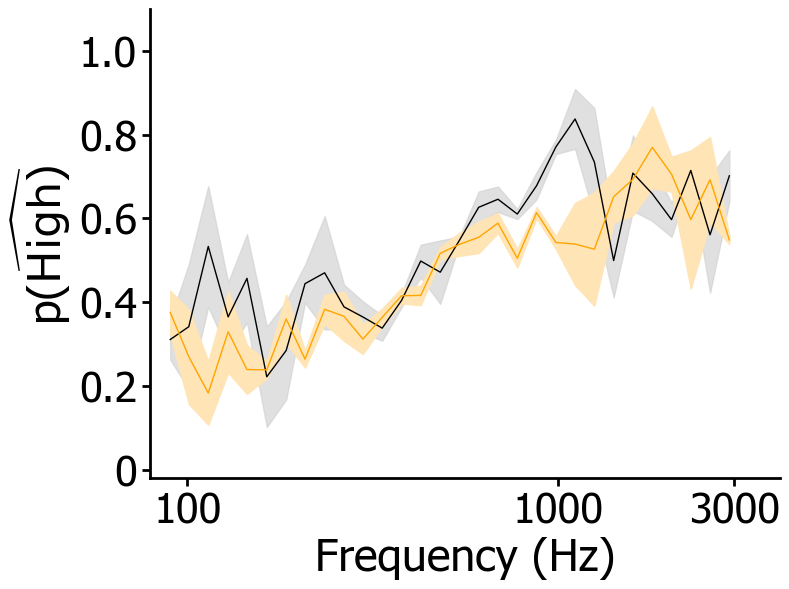

In [7]:
"""
Fitting the different models to the data
Note: the parameters used here are from the excel file present in the subjectData folder. 
"""
unique_tones_played, subjectBehaviour = plottingInfluenceFn(trial_tones, trial_behaviour) 

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.log10(unique_tones_played), np.mean(subjectBehaviour,axis=1),color='k',linewidth=1)
ax.fill_between(np.log10(unique_tones_played), 
                 y1 = np.mean(subjectBehaviour,axis=1) - np.std(subjectBehaviour,axis=1)/np.sqrt(3),
                 y2 = np.mean(subjectBehaviour,axis=1) + np.std(subjectBehaviour,axis=1)/np.sqrt(3),
                 color='lightgray',alpha=0.7)

ax.set_xlim([1.9,3.6])
ax.set_ylim([-0.02,1.1])
ax.set_xticks(ticks=np.log10([100,1000,3000]))
ax.set_xticklabels([100,1000,3000])
ax.tick_params(axis='both',labelsize=30,length=6,width=2)
ax.set_xlabel('Frequency (Hz)',fontsize=32)
ax.set_ylabel(r'p($\rm{\widehat{High}}$)',fontsize=32)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()


generatedTrainingTrials, generatedCorrAns, _, _, _ = task(freq_seq = expt_tones,
                                                       n_trials = 1000, n_tones = 3,
                                                       p_back=0.3, p_low=0.5,
                                                       lm=2.55,hm=2.85,s=0.1)

behaviourBasedOnSimulatedTones = 1

if behaviourBasedOnSimulatedTones:
    simulated_tones, simulated_behaviour, _ = generate_behaviour(generatedTrainingTrials, n_tones=3, 
                                                                 sigma_sensory=0.58,
                                                                 prob_back = [0.43,0.52,0.91],
                                                                 prob_low = 0.5,
                                                                 log_prior_params=[2.55,2.85,0.1])
else:
    simulated_tones, simulated_behaviour, _ = generate_behaviour(trial_tones, n_tones=3, 
                                                                 sigma_sensory=0.58,
                                                                 prob_back = [0.43,0.52,0.91],
                                                                 prob_low = 0.5,
                                                                 log_prior_params=[2.55,2.85,0.1])
    
    
"""
Characteristics of the simulated behaviour
"""

print("Accuracy of actual participant", np.mean(trial_behaviour == trial_corrans))
print("Accuracy of simulated participant", np.mean(np.squeeze(simulated_behaviour)==generatedCorrAns))

unique_tones_played, allTonePositionssubjectBehaviourModelled = plottingInfluenceFn(simulated_tones, 
                                                                                    simulated_behaviour) 

ax.plot(np.log10(unique_tones_played), np.mean(allTonePositionssubjectBehaviourModelled,axis=1),
        color='orange',linewidth=1)
ax.fill_between(np.log10(unique_tones_played), 
                 y1 = np.mean(allTonePositionssubjectBehaviourModelled,axis=1) - 
                np.std(allTonePositionssubjectBehaviourModelled,axis=1)/np.sqrt(3),
                 y2 = np.mean(allTonePositionssubjectBehaviourModelled,axis=1) + 
                np.std(allTonePositionssubjectBehaviourModelled,axis=1)/np.sqrt(3),
                 color='moccasin',alpha=1)


ax.set_xlim([1.9,3.6])
ax.set_ylim([-0.02,1.1])
ax.set_xticks(ticks=np.log10([100,1000,3000]))
ax.set_xticklabels([100,1000,3000])
ax.tick_params(axis='both',labelsize=30,length=6,width=2)
ax.set_xlabel('Frequency (Hz)',fontsize=32)
ax.set_ylabel(r'p($\rm{\widehat{High}}$)',fontsize=32)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
       
plt.savefig('figures/FromProlific/illustrations/experimenter=9b4b_tonePosDependentBayesian_exptPsychometricCurve.pdf',
           bbox_inches='tight',transparent=True)